In [ ]:
# Here we import useful modules
import gdown
import os
import pandas as pd
import random
from typing import Dict, List, Set, Iterable
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
All = pd.read_csv('/content/drive/My Drive/Colab Notebooks/WBE_sequencing/rerun/All_with_rank.csv')
All.head()

,taxID,date,method,Name,Rank_x,replicate,count
0,1,3/1,Solids,root,no_rank,1,3027748.0
1,2,3/1,Solids,Bacteria,superkingdom,1,2809024.0
2,1224,3/1,Solids,Pseudomonadota,phylum,1,1779812.0
3,1236,3/1,Solids,Gammaproteobacteria,class,1,1001924.0
4,33811,3/1,Solids,unclassified Gammaproteobacteria,no_rank,1,599.0


In [ ]:
kingdom = All[All["Rank_x"]=="kingdom"]
Virus_kingdom = kingdom[(kingdom["Name"] != 'Viridiplantae')&(kingdom["Name"] != 'Fungi')&(kingdom["Name"] != 'Metazoa')]
Virus_kingdom.head()

,taxID,date,method,Name,Rank_x,replicate,count
11680,2732396,3/1,Solids,Orthornavirae,kingdom,1,78.0
11706,2731360,3/1,Solids,Heunggongvirae,kingdom,1,10507.0
11795,2732090,3/1,Solids,Loebvirae,kingdom,1,257.0
11802,2732091,3/1,Solids,Sangervirae,kingdom,1,39.0
11809,2732092,3/1,Solids,Shotokuvirae,kingdom,1,434.0


In [ ]:
def classify_dna_rna(name):
    if name == 'Bamfordvirae':
        return 'DNA (double strand)'
    elif name == 'Heunggongvirae':
        return 'DNA (double strand)'
    elif name == 'Loebvirae':
        return 'DNA (single strand)'
    elif name == 'Orthornavirae':
        return 'RNA'
    elif name == 'Sangervirae':
        return 'DNA (single strand)'
    elif name == 'Shotokuvirae':
        return 'DNA (single strand)'

Virus_kingdom['DNA_RNA'] = Virus_kingdom['Name'].apply(classify_dna_rna)
Virus_kingdom["Samples"]=Virus_kingdom["method"]+"_"+Virus_kingdom["date"].astype(str)+"_"+Virus_kingdom["replicate"].astype(str)
Virus_kingdom=Virus_kingdom[Virus_kingdom["Samples"]!="PMG_4/26_2"]
Virus_kingdom.head()
vs = Virus_kingdom[["Samples","DNA_RNA","count"]]
print(vs["Samples"].unique())

['Solids_3/1_1' 'Solids_3/1_2' 'Solids_3/1_3' 'Solids_4/19_1'
 'Solids_4/19_2' 'Solids_4/19_3' 'Solids_4/26_1' 'Solids_4/26_2'
 'Solids_4/26_3' 'PMG_3/1_1' 'PMG_3/1_2' 'PMG_3/1_3' 'PMG_4/19_1'
 'PMG_4/19_2' 'PMG_4/19_3' 'PMG_4/26_1' 'PMG_4/26_3' 'IP_3/1_1' 'IP_3/1_2'
 'IP_3/1_3' 'IP_4/19_1' 'IP_4/19_2' 'IP_4/19_3' 'IP_4/26_1' 'IP_4/26_2'
 'IP_4/26_3' 'NT_3/1_1' 'NT_3/1_2' 'NT_3/1_3' 'NT_4/19_1' 'NT_4/19_2'
 'NT_4/19_3' 'NT_4/26_1' 'NT_4/26_2' 'NT_4/26_3']


In [ ]:
meta=pd.read_csv("/content/drive/My Drive/Colab Notebooks/WBE_sequencing/rerun/summary/Sequencing_results_summary_MJ - New_Reads_based_taxonomy_all (1).csv")
meta_drop=meta[meta["Samples"]!="PMG_4/26_2"]
Virus=meta_drop[["Viruses","Samples",'Unique_reads']]

In [ ]:
sum_kingdom = Virus_kingdom.groupby('Samples').agg(sum_kingdom=("count",'sum'))
sum_kingdom=sum_kingdom.reset_index()
combined = pd.merge(sum_kingdom,Virus,on="Samples",how="inner")
combined["kingdom-level unclassified"]=combined["Viruses"]-combined["sum_kingdom"]
k_unclassified = combined[["Samples","kingdom-level unclassified"]]
df_melted = pd.melt(k_unclassified, id_vars=['Samples'], value_vars=['kingdom-level unclassified'], var_name='DNA_RNA', value_name='count')
Final = pd.concat([df_melted, vs], ignore_index=True)
Final[['method', 'date', 'replicate']] = Final['Samples'].str.split("_", expand=True)
Final.head()

,Samples,DNA_RNA,count,method,date,replicate
0,IP_3/1_1,kingdom-level unclassified,9972.0,IP,3/1,1
1,IP_3/1_2,kingdom-level unclassified,11015.0,IP,3/1,2
2,IP_3/1_3,kingdom-level unclassified,8426.0,IP,3/1,3
3,IP_4/19_1,kingdom-level unclassified,2759.0,IP,4/19,1
4,IP_4/19_2,kingdom-level unclassified,2838.0,IP,4/19,2


In [ ]:
#Virus_kingdom["method_date"]=Virus_kingdom['method']+"_"+Virus_kingdom["date"].astype(str)
merge = pd.merge(Final,combined,on="Samples",how="inner")
merge["percentage"]=merge["count"]/merge["Unique_reads"]*100
summary3 = merge.groupby(["Samples",'DNA_RNA']).agg(
    percentage=("percentage", 'sum')).reset_index()
summary3=summary3.reset_index()
summary3[["method",'date','replicates']]=summary3["Samples"].str.split("_",expand=True)
summary3["method_date"]=summary3["method"]+"_"+summary3["date"]
summary_final=summary3.groupby(["method_date","DNA_RNA"]).agg(Percentage=("percentage",'mean'),std=("percentage",'std'))
summary_final=summary_final.reset_index()
summary_final[["method",'date']]=summary_final["method_date"].str.split("_",expand=True)
summary_final['cumulative_sum'] = summary_final.groupby(['method', 'date'])['Percentage'].cumsum()
#summary_final["DNA_RNA"] = summary_final["DNA_RNA"].replace("dsDNA", "DNA (double strand)")
#summary_final["DNA_RNA"] = summary_final["DNA_RNA"].replace("ssDNA", "DNA (single strand)")

#print(summary_final["DNA_RNA"].unique())
summary_final.head()
#summary_final["error_bar"]=100-summary_final["cumulative_sum"]+summary_final['Percentage']
#summary_final["error_bar"]=100-summary_final["cumulative_sum"]+summary_final['Percentage']
#summary_final.to_csv('/content/drive/My Drive/Colab Notebooks/WBE_sequencing/Final_results/DNA_RNA_unique_reads.csv')

,method_date,DNA_RNA,Percentage,std,method,date,cumulative_sum
0,IP_3/1,DNA (double strand),0.740386,0.050987,IP,3/1,0.740386
1,IP_3/1,DNA (single strand),0.047305,0.002865,IP,3/1,0.787692
2,IP_3/1,RNA,0.949607,0.188264,IP,3/1,1.737299
3,IP_3/1,kingdom-level unclassified,0.198652,0.009798,IP,3/1,1.935951
4,IP_4/19,DNA (double strand),0.345454,0.188552,IP,4/19,0.345454


/usr/local/lib/python3.10/dist-packages/plotnine/themes/themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


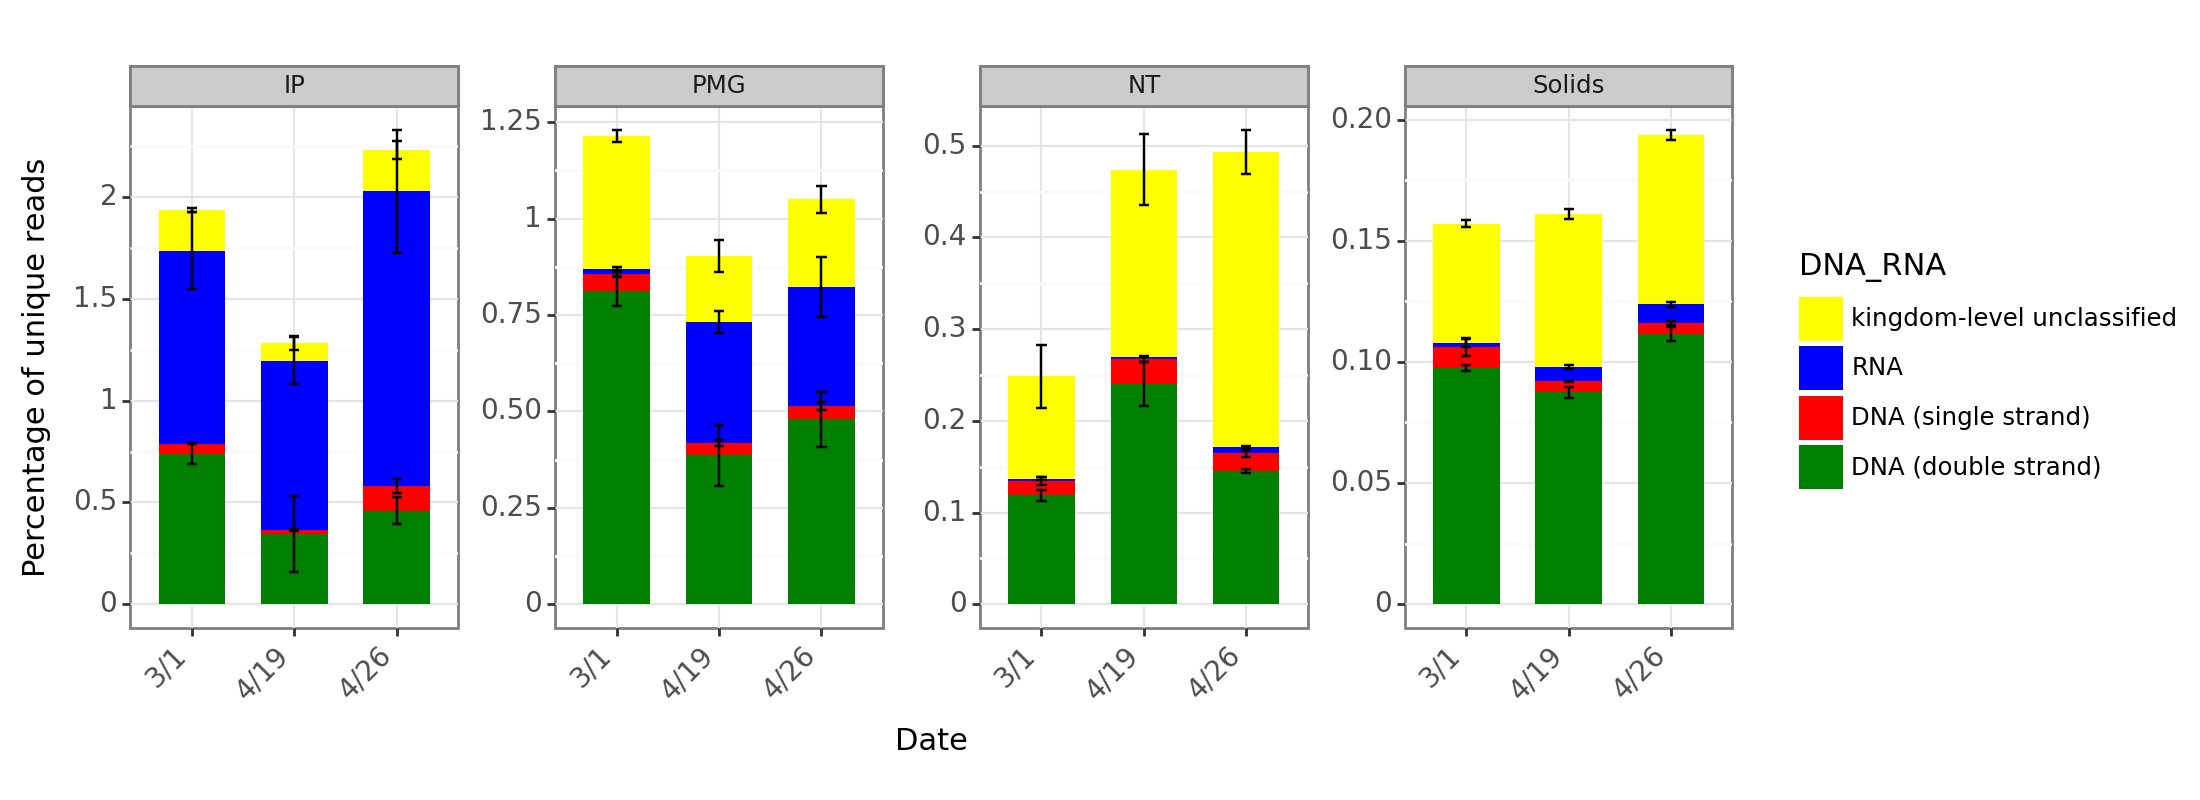

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 11 x 4 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /content/drive/My Drive/Colab Notebooks/WBE_sequencing/Final_results/DNA_RNA_NTSOlids_new.png
/usr/local/lib/python3.10/dist-packages/plotnine/themes/themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


In [ ]:
from plotnine import *
%matplotlib inline
summary_final['method'] = pd.Categorical(summary_final['method'], categories=["IP", "PMG", "NT","Solids"], ordered=True)
summary_final['DNA_RNA'] = pd.Categorical(summary_final['DNA_RNA'], categories=['kingdom-level unclassified','RNA','DNA (single strand)','DNA (double strand)'], ordered=True)
# Calculate the position for the error bars at the top center of each stacked bar
color_dict = {'RNA': 'red', 'kingdom-level unclassified': 'green','DNA (single strand)': 'blue','DNA (double strand)': 'yellow'}

plot = (
    ggplot(summary_final, aes(x='date', y='Percentage', fill='DNA_RNA')) +
    geom_bar(stat='identity', position=position_stack(), width=0.65) +
    geom_errorbar(aes(ymin='cumulative_sum-std', ymax='cumulative_sum+std', x="date"), width=0.1, position=position_identity(), color='black') +
    facet_wrap('~method', nrow=1,scales='free_y') +
    labs(y='Percentage of unique reads', x='Date') +
    scale_fill_manual(values=[color_dict[val] for val in summary_final['DNA_RNA'].unique()]) +  # Set specific colors
    theme_bw() +
    theme(
        axis_text_x=element_text(rotation=45, hjust=1, size=10),
        axis_text_y=element_text(size=10),
        subplots_adjust={'wspace': 0.15},
        figure_size=(11, 4),
        axis_title_y=element_text(size=11),
        axis_title_x=element_text(size=11)
    )
)

print(plot)
plot.save("/content/drive/My Drive/Colab Notebooks/WBE_sequencing/Final_results/DNA_RNA_NTSOlids_new.png", dpi=300)